# Análisis Exploratorio de Datos

El EDA de este proyecto se encuentra en el siguiente Dashboard:

https://nlp-app-t2xrr4crva7iww8bcqoytj.streamlit.app/

# Algoritmos de clasificación (RNN y LSTM) para el análisis de sentimiento.

In [ ]:
pip install keras-preprocessing xgboost imblearn

In [58]:
import pandas as pd
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, Bidirectional, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
from joblib import dump, load
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers.legacy import Adam
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


## Preparación de los datos

In [177]:
def leer_archivo(nombre_archivo):
    try:
        with open(nombre_archivo, "r", encoding="utf-8") as file:
            lineas = file.readlines()
    except UnicodeDecodeError:
        try:
            with open(nombre_archivo, "r", encoding="latin1") as file:
                lineas = file.readlines()
        except Exception as e:
            raise ValueError(f"Error al leer el archivo {nombre_archivo} con codificación UTF-8 o Latin1: {e}")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"El archivo {nombre_archivo} no se encontró. Por favor, verifica la ruta.") from e

    # Convertir las líneas a DataFrame y limpiar contenido
    df = pd.DataFrame(lineas, columns=["Contenido"])
    df["Contenido"] = df["Contenido"].str.strip()
    return df

# Rutas de los archivos
archivos = {
    "train": "/content/train.txt",
    "train_label": "/content/train_label.txt",
    "test": "/content/test.txt",
    "test_label": "/content/test_label.txt"
}

dataframes = {}

# Leer los archivos
try:
    for nombre, ruta in archivos.items():
        dataframes[nombre] = leer_archivo(ruta)
    train = dataframes["train"]
    train_label = dataframes["train_label"]
    test = dataframes["test"]
    test_label = dataframes["test_label"]
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error de codificación: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


In [178]:
train["Label"] = train_label["Contenido"]
test["Label"] = test_label["Contenido"]

In [ ]:
train.head()

,Contenido,Label
0,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,neu
1,คะ,neu
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,neg
3,😅😅😅,neu
4,สวัสดีวันพุธ แนน อะไรนะ,neu


In [67]:
train['Label'].value_counts()

,count
Label,
neu,13105
neg,6140
pos,4300
q,518


In [ ]:
test['Label'].value_counts()

,count
Label,
neu,1456
neg,683
pos,478
q,57


In [179]:
train = train[train['Label'].isin(['pos', 'neg'])].reset_index(drop=True)
test = test[test['Label'].isin(['pos', 'neg'])].reset_index(drop=True)

## Balanceo de datos

In [180]:
from imblearn.under_sampling import RandomUnderSampler

In [181]:
X_train = train.drop(columns=['Label'])
y_train = train['Label']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

train_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)


In [182]:
train_resampled['Label'].value_counts()

,count
Label,
neg,4300
pos,4300


## Pre procesamiento de datos

### Eliminar emojis

In [183]:
def contiene_emoji(texto):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002500-\U00002BEF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(texto))

train_resampled = train_resampled[~train_resampled["Contenido"].apply(contiene_emoji)]
test = test[~test["Contenido"].apply(contiene_emoji)]

train.head()

,Contenido,Label
0,อิเหี้ยออมทำกูอยากกินเอ็มเค,neg
1,เน็ตควายมากกูพูดจริงเสียดายตังค์ที่ติดตั้งเน็ต...,neg
2,เหล้าเบลล์รสชาติเหี้ยสุด จะไม่แดกอีกละ,neg
3,สนใจ ฟอจูนเนอร์ สีขาวครับ,pos
4,ลิปมันของเเบร์น Mistine ราคากลาง ๆ ไม่แพงมาก ร...,neg


In [184]:
train_resampled = train_resampled.rename(columns={'Contenido': 'Comment', 'Label': 'Sentiment'})
test = test.rename(columns={'Contenido': 'Comment', 'Label': 'Sentiment'})

In [185]:
train_resampled['Category'] = train_resampled['Sentiment'].map({'neg': 0, 'pos': 1})
test['Category'] = test['Sentiment'].map({'neg': 0, 'pos': 1})

### Tokenización

In [186]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [187]:
X_train_full = train_resampled['Comment']
Y_train_full = pd.get_dummies(train_resampled['Sentiment']).values

X_test = test['Comment']
Y_test = pd.get_dummies(test['Sentiment']).values

X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.15, random_state=42)

print("Tamaños:")
print(f"X_train: {len(X_train)}, Y_train: {len(Y_train)}")
print(f"X_val: {len(X_val)}, Y_val: {len(Y_val)}")
print(f"X_test: {len(X_test)}, Y_test: {len(Y_test)}")

Tamaños:
X_train: 6611, Y_train: 6611
X_val: 1167, Y_val: 1167
X_test: 1044, Y_test: 1044


In [188]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

## Construcción y Entrenamiento de Modelo LSTM

In [189]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(64))
model.add(Dense(Y_train_full.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [190]:
history_lstm = None
if os.path.exists('history_lstm.joblib'):
    history_lstm = load('history_lstm.joblib')
    print("El archivo 'history_lstm.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history = model.fit(X_train_seq, Y_train, epochs=30, batch_size=32, verbose=2)
    dump(history.history, 'history_lstm.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_lstm.joblib'.")

Epoch 1/30
207/207 - 11s - loss: 0.6850 - accuracy: 0.5456 - 11s/epoch - 53ms/step
Epoch 2/30
207/207 - 9s - loss: 0.5630 - accuracy: 0.6751 - 9s/epoch - 43ms/step
Epoch 3/30
207/207 - 9s - loss: 0.4721 - accuracy: 0.7041 - 9s/epoch - 44ms/step
Epoch 4/30
207/207 - 9s - loss: 0.4481 - accuracy: 0.7061 - 9s/epoch - 43ms/step
Epoch 5/30
207/207 - 9s - loss: 0.4343 - accuracy: 0.7112 - 9s/epoch - 44ms/step
Epoch 6/30
207/207 - 9s - loss: 0.4241 - accuracy: 0.7176 - 9s/epoch - 43ms/step
Epoch 7/30
207/207 - 9s - loss: 0.4151 - accuracy: 0.7191 - 9s/epoch - 43ms/step
Epoch 8/30
207/207 - 9s - loss: 0.4090 - accuracy: 0.7282 - 9s/epoch - 43ms/step
Epoch 9/30
207/207 - 9s - loss: 0.4044 - accuracy: 0.7232 - 9s/epoch - 44ms/step
Epoch 10/30
207/207 - 9s - loss: 0.4010 - accuracy: 0.7229 - 9s/epoch - 43ms/step
Epoch 11/30
207/207 - 9s - loss: 0.3985 - accuracy: 0.7261 - 9s/epoch - 42ms/step
Epoch 12/30
207/207 - 9s - loss: 0.3940 - accuracy: 0.7259 - 9s/epoch - 43ms/step
Epoch 13/30
207/207 - 9

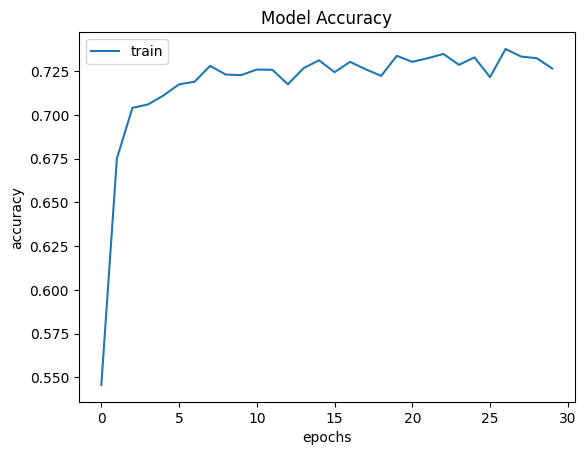

In [191]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left');

### Evaluación del Modelo LSTM

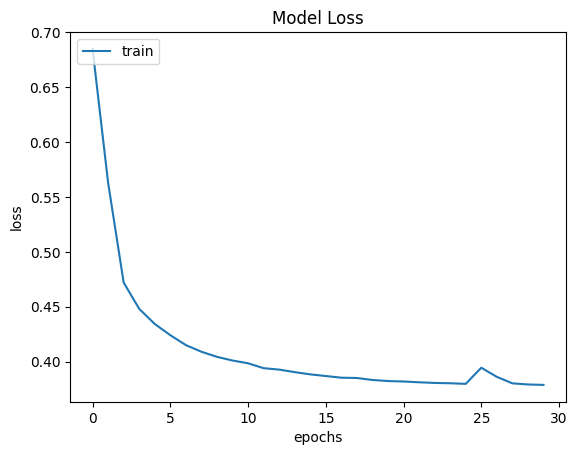

In [192]:
plt.plot(history.history['loss']);
plt.title('Model Loss');
plt.ylabel('loss');
plt.xlabel('epochs');
plt.legend(['train', 'test'], loc='upper left');

In [193]:
_, train_acc = model.evaluate(X_train_seq, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test_seq, Y_test, verbose=2)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

207/207 - 3s - loss: 0.3759 - accuracy: 0.7394 - 3s/epoch - 15ms/step
33/33 - 0s - loss: 1.1488 - accuracy: 0.4943 - 465ms/epoch - 14ms/step
Train: 0.739, Test: 0.494
Train: 0.739, Test: 0.4943


In [194]:
yhat_probs = model.predict(X_test_seq, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)

In [195]:
rounded_labels=np.argmax(Y_test, axis=1)

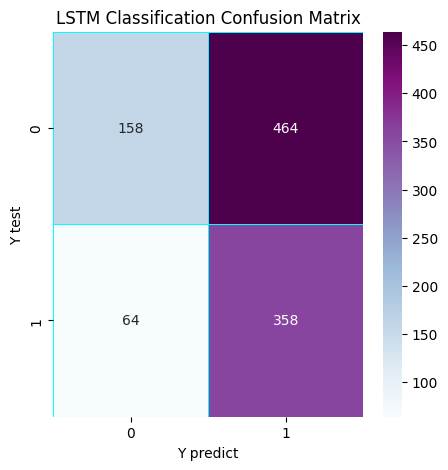

In [196]:
from sklearn.metrics import confusion_matrix

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [197]:
model.save('lstm_model.h5')

## Construcción y Evaluación del Modelo RNN

In [198]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_RNN.add(SimpleRNN(64))
model_RNN.add(Dense(Y_train_full.shape[1], activation='softmax'))
model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [199]:
history_RNN = None
if os.path.exists('history_RNN.joblib'):
    history_RNN = load('history_RNN.joblib')
    print("El archivo 'history_RNN.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history_RNN = model_RNN.fit(X_train_seq, Y_train, epochs=30, batch_size=32, verbose=2)
    dump(history.history, 'history_RNN.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_RNN.joblib'.")

Epoch 1/30
207/207 - 7s - loss: 0.6832 - accuracy: 0.5359 - 7s/epoch - 32ms/step
Epoch 2/30
207/207 - 6s - loss: 0.5236 - accuracy: 0.7000 - 6s/epoch - 27ms/step
Epoch 3/30
207/207 - 6s - loss: 0.4315 - accuracy: 0.7173 - 6s/epoch - 27ms/step
Epoch 4/30
207/207 - 6s - loss: 0.4151 - accuracy: 0.7232 - 6s/epoch - 28ms/step
Epoch 5/30
207/207 - 6s - loss: 0.4056 - accuracy: 0.7282 - 6s/epoch - 28ms/step
Epoch 6/30
207/207 - 6s - loss: 0.4002 - accuracy: 0.7235 - 6s/epoch - 27ms/step
Epoch 7/30
207/207 - 6s - loss: 0.3975 - accuracy: 0.7295 - 6s/epoch - 27ms/step
Epoch 8/30
207/207 - 6s - loss: 0.3951 - accuracy: 0.7233 - 6s/epoch - 28ms/step
Epoch 9/30
207/207 - 6s - loss: 0.3939 - accuracy: 0.7288 - 6s/epoch - 27ms/step
Epoch 10/30
207/207 - 6s - loss: 0.3935 - accuracy: 0.7247 - 6s/epoch - 28ms/step
Epoch 11/30
207/207 - 6s - loss: 0.4841 - accuracy: 0.7056 - 6s/epoch - 27ms/step
Epoch 12/30
207/207 - 6s - loss: 0.4066 - accuracy: 0.7221 - 6s/epoch - 27ms/step
Epoch 13/30
207/207 - 6s 

### Evaluación del Modelo RNN

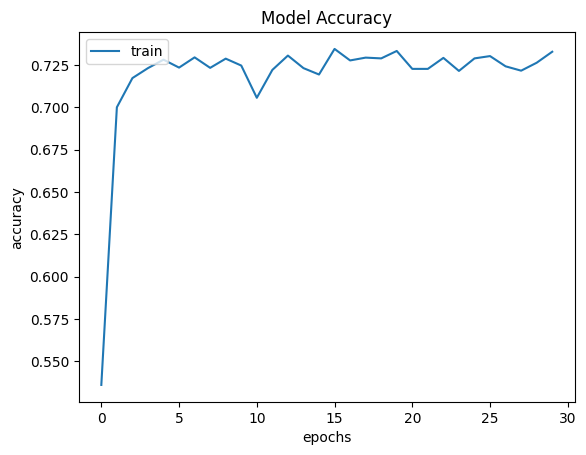

In [200]:
plt.plot(history_RNN.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left');

In [201]:
_, train_acc = model_RNN.evaluate(X_train_seq, Y_train, verbose=2)
_, test_acc = model_RNN.evaluate(X_test_seq, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

207/207 - 2s - loss: 0.3820 - accuracy: 0.7376 - 2s/epoch - 7ms/step
33/33 - 0s - loss: 0.8236 - accuracy: 0.4933 - 226ms/epoch - 7ms/step
Train: 0.738, Test: 0.4933


In [202]:
yhat_probs = model_RNN.predict(X_test_seq, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)

In [203]:
rounded_labels=np.argmax(Y_test, axis=1)

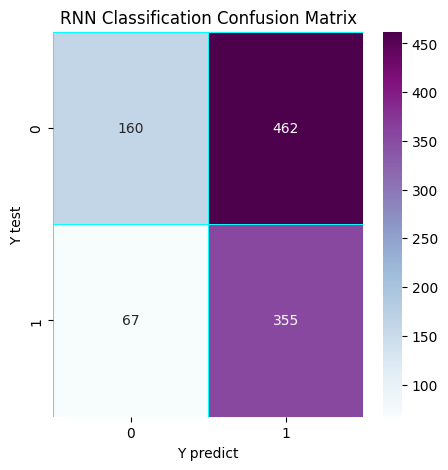

In [204]:
RNN_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(RNN_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('RNN Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [205]:
model_RNN.save('RNN_model.h5')

# Modelo Propuesto: LSTM y XGBOOST

In [206]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(Y_train_full.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=True)

In [208]:
history_lstm = None
if os.path.exists('history_Modelo_Nuevo.joblib'):
    history_lstm = load('history_Modelo_Nuevo.joblib')
    print("El archivo 'history_Modelo_Nuevo.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history = model.fit(X_train_seq, Y_train, epochs=30, batch_size=32, verbose=2)
    dump(history.history, 'history_Modelo_Nuevo.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_lstm.joblib'.")

Epoch 1/30
207/207 - 126s - loss: 0.6852 - accuracy: 0.5402 - 126s/epoch - 609ms/step
Epoch 2/30
207/207 - 126s - loss: 0.5668 - accuracy: 0.6761 - 126s/epoch - 610ms/step
Epoch 3/30
207/207 - 126s - loss: 0.4743 - accuracy: 0.6973 - 126s/epoch - 608ms/step
Epoch 4/30
207/207 - 127s - loss: 0.4484 - accuracy: 0.7073 - 127s/epoch - 613ms/step
Epoch 5/30
207/207 - 127s - loss: 0.4335 - accuracy: 0.7159 - 127s/epoch - 612ms/step
Epoch 6/30
207/207 - 126s - loss: 0.4243 - accuracy: 0.7155 - 126s/epoch - 611ms/step
Epoch 7/30
207/207 - 126s - loss: 0.4194 - accuracy: 0.7161 - 126s/epoch - 611ms/step
Epoch 8/30
207/207 - 126s - loss: 0.4102 - accuracy: 0.7149 - 126s/epoch - 606ms/step
Epoch 9/30
207/207 - 125s - loss: 0.4039 - accuracy: 0.7286 - 125s/epoch - 604ms/step
Epoch 10/30
207/207 - 126s - loss: 0.4002 - accuracy: 0.7223 - 126s/epoch - 608ms/step
Epoch 11/30
207/207 - 126s - loss: 0.3962 - accuracy: 0.7279 - 126s/epoch - 609ms/step
Epoch 12/30
207/207 - 126s - loss: 0.3932 - accuracy

In [209]:
lstm_model = Sequential(model.layers[:-1])
X_train_embeddings = lstm_model.predict(X_train_seq)
X_test_embeddings = lstm_model.predict(X_test_seq)

33/33 [==============================] - 1s 20ms/step


In [210]:
Y_test = np.argmax(Y_test, axis=1)
Y_train = np.argmax(Y_train, axis=1)

In [215]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_embeddings, Y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:")
print(best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_embeddings)
accuracy = accuracy_score(Y_test, y_pred)
print("Precisión del modelo XGBoost:", accuracy)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [216]:
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.25      0.38       622
           1       0.44      0.88      0.59       422

    accuracy                           0.51      1044
   macro avg       0.60      0.57      0.48      1044
weighted avg       0.63      0.51      0.46      1044



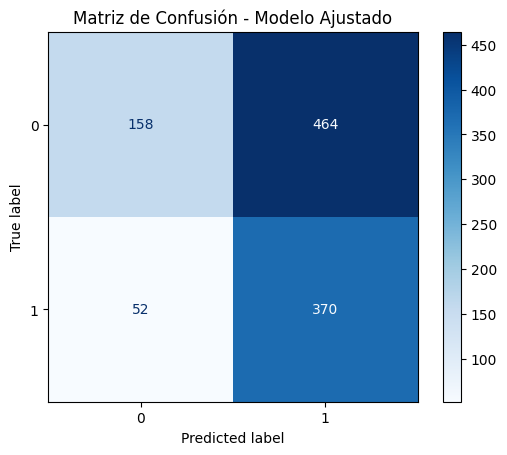

In [218]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test_embeddings)

conf_matrix = confusion_matrix(Y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Modelo Ajustado")
plt.show()